<a href="https://colab.research.google.com/github/MarioSigal/Elementos-de-Reconocimiento-Visual/blob/main/Laboratorios/Laboratorio5_Minimo_N_CUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Nombre del Grupo*: Nosotres

*Integrantes*: Lautaro Masetto, Matias Halperin, Leonardo Dominguez, Mario Sigal Aguirre

## **Laboratorio 5: Minimo N-Cut**

In [ ]:
from skimage import data, transform
import numpy as np
import gc

In [ ]:
def matriz_afinidad(img, sigma_color=0.1, sigma_spatial=10, radius=18):
    h, w, c = img.shape
    #Calculamos la matriz de adyacencia de cada uno de los pixeles al resto
    weights = np.zeros((h, w, h, w), dtype=np.float16)

    yv, xv = np.mgrid[0:h, 0:w]

    for i in range(h):
        for j in range(w):
            # Calculamos el valor de distancia al resto de los pixeles
            spatial_dists_sq = (xv - j)**2 + (yv - i)**2
            mask = spatial_dists_sq <= radius**2 # Mascara para ignorar quienes esten afuera del rango

            # similaridad del color
            color_dist_sq = np.sum((img[i, j] - img)**2, axis=-1)

            # similaridad del pixel i,j con el resto
            similarity = np.exp(-(color_dist_sq / (2 * sigma_color**2) +
                                  spatial_dists_sq / (2 * sigma_spatial**2)))

            weights[i, j] = (similarity * mask).astype(np.float16)

        if i % 10 == 0:
            print(f"Row {i}/{h}")

    # Borramos todo antes de irnos para ahorrar memoria
    del spatial_dists_sq
    del mask
    del color_dist_sq
    del similarity
    gc.collect()

    return np.reshape(weights, (h*w, -1))

Visualizamos la similud de un pixel y su zona

Row 0/50
Row 10/50
Row 20/50
Row 30/50
Row 40/50


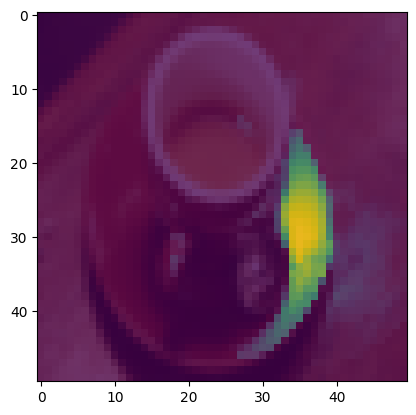

In [ ]:
import matplotlib.pyplot as plt

PIXEL= (35,30)

image = transform.resize(data.coffee(),(50,50))
matri_afinidad = matriz_afinidad(image)

# Veamos la afinidad de un pixel como un mapa de calor
afinidad_pixel = np.reshape(matri_afinidad, (image.shape[0], image.shape[1], image.shape[0], image.shape[1]))

fig, ax = plt.subplots(1)

ax.imshow(image)
ax.imshow(afinidad_pixel[PIXEL[1],PIXEL[0]],alpha=0.75)

# Show the plot
plt.show()


In [ ]:
import numpy as np

def costo_norm_cut(particion, L, degrees):
    """
    Particion debe tener como valores a 1 y -1
    """
    x = particion

    # Calculamos el costo, es decir, la similaridad que tenian las conecciones,
    # entre los nodos de distintas particiones
    # multiplicacion matriz vector: @

    # Encontramos cuales pertenecen a A
    mask_A = (x == 1)

    # Encontramos cuales pertenecen a B
    mask_B = (x == -1)

    n = L.shape[0]

    cut_cost = 0
    for i in range(n):
        if mask_A[i]:
            for j in range(n):
                if mask_B[j]:
                    cut_cost += L[i,j]


    """
    Con Laplaciano:
    cut_cost = x @ L @ x

    No hace falta usar las mascaras

    Ademas, habria que modificar la funcion recursive_partition, la linea
    min_cut_threshold, min_cost = umbral_menor_costos(V2, 20, W_sub, degrees) -> esto lo modifique yo
    habria que cambiarla por
    min_cut_threshold, min_cost = umbral_menor_costos(V2, 20, L, degrees) -> esto es lo que estaba en el codigo original de juan
    o sea, le pasas el laplaciano en vez de la matriz de afinidad

    """

    # Sumamos la similitud que tiene cada particion para normalizar
    assoc_A = 0
    for i in range(n):
      if mask_A[i]:
        assoc_A += degrees[i]

    assoc_B = 0
    for i in range(n):
      if mask_B[i]:
        assoc_B += degrees[i]

    if assoc_A == 0 or assoc_B == 0:
        return np.inf

    # Normalizamos
    ncut_cost = cut_cost/assoc_A + cut_cost/assoc_B

    return ncut_cost

In [ ]:
def umbral_menor_costos(V2, points, L, degrees):
  # Encontramos el mejor umbral que genere el corte mas 'barato'
  # Probamos con los valores que se encuentran dentro del autovector
  thresholds = np.linspace(V2.min(), V2.max(), points)
  best_cost = np.inf
  best_threshold = None

  for t in thresholds:
    partition = np.where(V2 > t, 1, -1)
    cost = costo_norm_cut(partition, L, degrees)
    if cost < best_cost:
        best_cost = cost
        best_threshold = t

  return best_threshold, best_cost

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh

def recursive_partition(image, c, radius = 30):
  # Particionamos una imagen recursivamente hasta que la disimilaridad de los segmentos
  # sean menor a c
  h, w, channels = image.shape
  n_pixels = h * w

  # Computamos la matriz de similaridad entre todos los pixeles
  W = matriz_afinidad(image,radius=radius)
  partitions = []
  un_partitioned_segments = [np.arange(n_pixels)] # el primer segmento es toda la imagen
  numero_particion = 0

  while un_partitioned_segments:

    print(f"Particion nro: {numero_particion}")

    numero_particion += 1

    segment_indices = un_partitioned_segments.pop()
    if len(segment_indices) < 10:
        partitions.append(segment_indices)
        continue  # ignoramos segmentos chicos

    # Utilizamos unicamente los pixeles que pertenecen a esta segmentacion
    W_sub = W[np.ix_(segment_indices, segment_indices)]

    # calculamos el Laplaciano del grafo
    n = W_sub.shape[0]
    degrees = np.zeros(n)
    for i in range(n):
        for j in range(n):
            degrees[i] += W_sub[i,j]

    D = np.diag(degrees)

    L = D - W_sub

    # Encontramos el seguno autovector mas chico, ya que el primero es 0.
    eigenvalues, eigenvectors = eigsh(L, k=2, M=D, which='SM')
    V2 = eigenvectors[:, 1]

    # Encontramos el mejor umbral
    min_cut_threshold, min_cost = umbral_menor_costos(V2, 20, W_sub, degrees)

    # Si el costo es mayor a c, detenemos la segmentacion
    if min_cost > c:
      partitions.append(segment_indices)
      continue

    # Separamos los indices encontrados en dos grupos y los agregamos a la pila
    mask = (V2 > min_cut_threshold)
    group_A = segment_indices[mask]
    group_B = segment_indices[~mask]

    un_partitioned_segments.extend([group_A, group_B])

  # Finalemnte, unimos todas las labels en una sola imagen
  label_map = np.zeros(n_pixels, dtype=int)
  for i, seg in enumerate(partitions):
      label_map[seg] = i + 1

  return label_map.reshape((h, w))


In [ ]:
import matplotlib.pyplot as plt

image=transform.resize(data.coffee(),(50,50))

#encontramos los segmentos
segmentos = recursive_partition(image,0.75, radius=10)


Row 0/50
Row 10/50
Row 20/50
Row 30/50
Row 40/50
Particion nro: 0
Particion nro: 1
Particion nro: 2
Particion nro: 3
Particion nro: 4
Particion nro: 5
Particion nro: 6
Particion nro: 7
Particion nro: 8
Particion nro: 9
Particion nro: 10
Particion nro: 11
Particion nro: 12
Particion nro: 13
Particion nro: 14
Particion nro: 15
Particion nro: 16
Particion nro: 17
Particion nro: 18
Particion nro: 19
Particion nro: 20
Particion nro: 21
Particion nro: 22
Particion nro: 23
Particion nro: 24
Particion nro: 25
Particion nro: 26
Particion nro: 27
Particion nro: 28
Particion nro: 29
Particion nro: 30
Particion nro: 31
Particion nro: 32
Particion nro: 33
Particion nro: 34
Particion nro: 35
Particion nro: 36
Particion nro: 37
Particion nro: 38
Particion nro: 39
Particion nro: 40
Particion nro: 41
Particion nro: 42
Particion nro: 43
Particion nro: 44
Particion nro: 45
Particion nro: 46
Particion nro: 47
Particion nro: 48
Particion nro: 49
Particion nro: 50
Particion nro: 51
Particion nro: 52
Partici

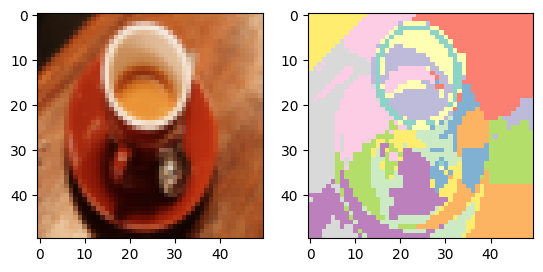

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(image)

ax[1].imshow(segmentos,cmap="Set3")

plt.show()